# A Bayesian Approach to Quadrature (Numerical Integration)
$$
\newcommand{\Bern}{\mathrm{Bern}}
\newcommand{\Bin}{\mathrm{Bin}}
\newcommand{\Ex}{\mathbb{E}}
\newcommand{\Var}{\mathrm{Var}}
\newcommand{\phat}{\widehat{p}}
\newcommand{\Ybar}{\overline{Y}}
\newcommand{\zalpha}{z_{1-\alpha/2}}
\newcommand{\GP}{\mathrm{GP}}
\newcommand{\vf}{\boldsymbol{f}}
\newcommand{\vk}{\boldsymbol{k}}
\newcommand{\vy}{\boldsymbol{y}}
\newcommand{\mK}{\mathsf{K}}
$$
The __trapezoidal rule__ is used to approximate integrals when one cannot do so analytically.  One may derive this rule via a Bayesian statistical approach.

We assume that the integrand, $f$, is a random function, in particular an instance of a Gaussian stochastic process, i.e., $f \sim \GP(0, K)$.  Here the mean of $f$ is assumed to be the zero function, and $K$ describes how much values of the function vary from place to place:

- $\Ex[f(x)] =  0$ 

- $\Ex\bigl[f(t)f(x) \bigr] = K(t,x)$ for some specified covariance kernel, $K$

- What is the **population**?  All continuous functions
- Why are we **sampling**?  Because the function is too complex to integrate by hand

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import classlib as cl
%matplotlib inline
cl.nbviz.init(use_tex=True)
cl.nbviz.configure(figpath="_figures/approval_rating", savefigs=True, imgfrmt="png")  #change to "...figures/..." to track
colors = cl.nbviz.TOL_BRIGHT

## Bayesian Posterior Function Approximation
The Bayesian posterior mean of the $f(x)$ for an arbitrary $x$ conditioned on the data 

$$
\vf := 
\begin{pmatrix}
f(x_1) \\
\vdots \\
f(x_n)
\end{pmatrix} =
\begin{pmatrix} 
y_1 \\
\vdots \\
y_n
\end{pmatrix} =: \vy
$$
is given by 
$$
\Ex\bigl[f(x) \mid \vf  = \vy\bigr] = \vy^\top \mK^{-1} \vk(x) , \qquad 
\text{where } \vk(x) = \bigl( K(x,x_i) \bigr)_{i=1}^n, \quad \bigl(K(x_i,x_j)\bigr)_{i,j=1}^n =: \mK
$$

We show some plots for the special case $K(t,x) = 2 - \lvert t - x \rvert$

### Functions to work with kernels

Here is a our kernel example with its integrals, which we will use later

In [3]:
def K_abs(t, x):
    # Vectorized covariance kernel: works for scalars or numpy arrays via broadcasting
    t = np.asarray(t)
    x = np.asarray(x)
    return 2.0 - np.abs(t - x)

K_abs.label = r"$K(t,x)=2-\lvert t-x\rvert$"

# ---- Attach integration metadata and methods (domain [0,1], uniform measure) ----
K_abs.domain = (0.0, 1.0)
K_abs.measure = "uniform"

def _K_abs_int_t(x, a=0.0, b=1.0):
    """
    Single integral in the FIRST argument:
        kbar(x) = ∫_a^b K(t, x) dt
    For K(t,x)=2-|t-x| on [0,1]:
        kbar(x) = 2(b-a) - ∫|t-x|dt
    Specialized closed form below assumes a=0,b=1.
    """
    if (a, b) != (0.0, 1.0):
        raise NotImplementedError("Closed form implemented only for [0,1].")

    x = np.asarray(x)
    return 1.5 + x - x**2  # = 2 - 0.5*(x^2 + (1-x)^2)

def _K_abs_int_tx(a=0.0, b=1.0):
    """
    Double integral:
        kbb = ∫_a^b ∫_a^b K(t, x) dt dx
    For K(t,x)=2-|t-x| on [0,1], kbb = 5/3.
    """
    if (a, b) != (0.0, 1.0):
        raise NotImplementedError("Closed form implemented only for [0,1].")

    return 5.0 / 3.0

# Attach as callable attributes
K_abs.int_t = _K_abs_int_t        # vectorized in x
K_abs.int_tx = _K_abs_int_tx      # scalar

Here are some functions to return the Gram matrix and the kernel vector

In [4]:
def kernel_tools(K, x, *, return_gram=True, return_kfun=True, dtype=float):
    """
    Given a kernel K(t,x) and nodes x = (x1,...,xn), return:
      - Gram matrix G[i,j] = K(xi, xj)  (optional)
      - a function k(t) = [K(t,x1),...,K(t,xn)] (optional)

    Parameters
    ----------
    K : callable
        Vectorized kernel supporting broadcasting, e.g.
        K(X[:,None], X[None,:]) -> (n,n) and K(t, X) -> (n,)
    x : array-like, shape (n,)
        Nodes x1,...,xn
    return_gram : bool
    return_kfun : bool
    dtype : type
        dtype for outputs

    Returns
    -------
    G and/or k depending on flags.
    """
    x = np.asarray(x, dtype=float).reshape(-1)
    out = []

    if return_gram:
        G = np.asarray(K(x[:, None], x[None, :]), dtype=dtype)
        out.append(G)

    if return_kfun:
        def k(t):
            t = np.asarray(t, dtype=float)
            Phi = K(t[..., None], x[None, ...])    # shape (..., n)
            return np.asarray(Phi, dtype=dtype)
        out.append(k)

    return out[0] if len(out) == 1 else tuple(out)

def kernel_interpolant(K, x_nodes, f):
    x_nodes = np.asarray(x_nodes, dtype=float).reshape(-1)

    G, k = kernel_tools(K, x_nodes)   # <-- use your kernel_tools
    y = f(x_nodes)
    c = np.linalg.solve(G, y)

    def f_hat(x):
        x = np.asarray(x, dtype=float)
        Phi = K(x[..., None], x_nodes[None, ...])  # shape (..., n)
        return Phi @ c

    return c, f_hat, G, y, x_nodes

### Test function
Here is a test function that we will use for illustration

In [5]:
def make_f_gauss(a):  #a is the parameter that determines the decay
    def f(x):
        x = np.asarray(x)
        return np.exp(-a * x**2)

    f.a = a
    f.label  = rf"$f(x)=e^{{-{a}x^2}}$"
    f.domain = (0.0, 1.0)

    def _integral(a0=0.0, b0=1.0):
        sa = np.sqrt(a)
        return 0.5 * np.sqrt(np.pi) / sa * (math.erf(sa*b0) - math.erf(sa*a0))

    f.integral = _integral
    return f

### An example of function approximation

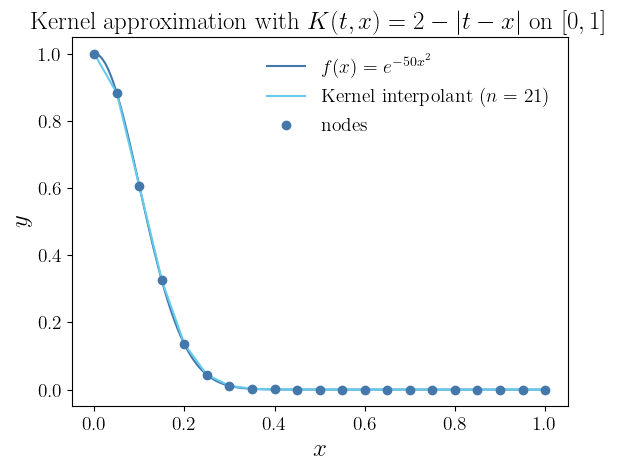

||error||_inf = 0.02800791172786432
||error||_2   = 0.005804296438345759


In [6]:
K = K_abs                 # swap to others
f = make_f_gauss(a=50)    # swap to others

n = 21 #the number of nodes = the number of intervals + 1
x_nodes = np.linspace(0.0, 1.0, n, endpoint=True)
c, f_hat, G, y, x_nodes = kernel_interpolant(K, x_nodes, f)

x_grid = np.linspace(0.0, 1.0, max(1000,50*n))

plt.figure()
plt.plot(x_grid, f(x_grid), label=getattr(f, "label", "f"))
plt.plot(x_grid, f_hat(x_grid), label=rf"Kernel interpolant ($n={n}$)")
plt.scatter(x_nodes, y, marker="o", label="nodes", zorder=3)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title(rf"Kernel approximation with {getattr(K, 'label', 'K')} on $[0,1]$")
plt.legend()
plt.show()

err_inf = np.max(np.abs(f_hat(x_grid) - f(x_grid)))
err_l2 = np.sqrt(np.trapezoid((f_hat(x_grid) - f(x_grid))**2, x_grid))
print("||error||_inf =", err_inf)
print("||error||_2   =", err_l2)


## Bayesian Posterior Integration 
Now we do the integration problem. The function below defines the approximate integral in terms of the integral of the kernel.

In [7]:
def kernel_quadrature(K, x_nodes, f):
    """
    Kernel (Bayesian) quadrature using the same ingredients as kernel_interpolant.

    Requires the kernel to provide:
        K.int_t(x)  = ∫_0^1 K(t, x) dt   (vectorized in x)

    Returns
    -------
    w : ndarray, shape (n,)
        Quadrature weights so that I_hat = w^T y
    I_hat : float
        Integral estimate of f over [0,1]
    y : ndarray, shape (n,)
        Function values at the nodes
    G : ndarray, shape (n,n)
        Gram matrix
    kbar : ndarray, shape (n,)
        Integrated-kernel vector at the nodes
    """
    x_nodes = np.asarray(x_nodes, dtype=float).reshape(-1)

    if not hasattr(K, "int_t"):
        raise AttributeError("Kernel must have attribute K.int_t(x) = ∫ K(t,x) dt on the domain.")

    G = gram_matrix(K, x_nodes) if "gram_matrix" in globals() else np.asarray(K(x_nodes[:,None], x_nodes[None,:]), dtype=float)
    y = np.asarray(f(x_nodes), dtype=float).reshape(-1)

    kbar = np.asarray(K.int_t(x_nodes), dtype=float).reshape(-1)   # ∫ K(t, x_i) dt
    w = np.linalg.solve(G, kbar)

    I_hat = float(w @ y)
    return w, I_hat, y, G, kbar

For the test function shown above and the absolute value kernel we get the following approximation and error

In [8]:
w, I_hat, y, G, kbar = kernel_quadrature(K, x_nodes, f)
print("Kernel quadrature estimate:", I_hat)

if hasattr(f, "integral"):
    I_exact = f.integral()
    err = I_hat - I_exact
    rel_err = err / I_exact if I_exact != 0 else np.nan

    print("Exact integral:", I_exact)
    print("Error:", err)
    print("Relative error:", rel_err)

Kernel quadrature estimate: 0.12533141373155005
Exact integral: 0.12533141373155002
Error: 2.7755575615628914e-17
Relative error: 2.2145745259906796e-16


We notice that the quadrature waits are the same as the **trapezoidal rule** for the absolute value kernel

In [9]:
print("first several quadrature weights:", w[:5])
print("last several quadrature weights: ", w[-5:])

first quadrature weights: [0.025 0.05  0.05  0.05  0.05 ]
last quadrature weights:  [0.05  0.05  0.05  0.05  0.025]
